CAMPAIGNS TO ANALYZE (and their column names)

1) GOAMAZON
    SS_A - SS_B
    CCN_Conc_A - CCN_Conc_B
    WCM_083(g/m3) - WCM_021(g/m3)

2) ACE-ENA

3) ISDAC

4) ACMEV
    WCM_083(g/m3) - WCM_021(g/m3)

5) CACTI
    CCN_supersaturation_set_point_1 - CCN_supersaturation_set_point_2
    N_CCN_1 - N_CCN_2

6) TCAP
    SS_A(%) - SS_B(%)
    CCN_Conc_A(#/cc) - CCN_Conc_B(#/cc)

7) BBOP
    WCM_083 - WCM_021
    SS_A - SS_B
    CCN_Conc_A - CCN_Conc_B

8) CARES
    


In [ ]:
import pandas as pd
import icartt
import os
import warnings
import re
from datetime import datetime
import csv
from datetime import datetime, timedelta
from netCDF4 import Dataset
import matplotlib.pyplot as plt

raw_path = rf"C:\Users\haika\Desktop\May_Research\may_datasets\raw_campaigns"

CAMPAIGN_DATA = {
    "GOAMAZON" : [["ccn_SS_A", "ccn_SS_B"], ["ccn_CCN_Conc_A", "ccn_CCN_Conc_B"], ["wcm_WCM_083(g/m3)", "wcm_WCM_021(g/m3)"]],
    "ACMEV" : [["wcm_WCM_083(g/m3)", "wcm_WCM_021(g/m3)"]],
    "CACTI" : [["ccn_CCN_supersaturation_set_point_1", "ccn_CCN_supersaturation_set_point_2"], ["ccn_N_CCN_1", "ccn_N_CCN_2"]],
    "TCAP2012" : [["ccn_SS(%)_A", "ccn_SS(%)_B"], ["ccn_CCN_Conc_A", "ccn_CCN_Conc_B"]],
    "TCAP2013" : [["ccn_SS_A(%)", "ccn_SS_B(%)"], ["ccn_CCN_Conc_A(#/cc)", "ccn_CCN_Conc_B(#/cc)"]],
    "BBOP" : [["ccn_SS_A", "ccn_SS_B"], ["ccn_CCN_Conc_A", "ccn_CCN_Conc_B"], ["wcm_WCM_083", "wcm_WCM_021"]],
}



In [18]:
def plot_columns(df, campaign_title, col1, col2):
    """
    Plot col1 and col2 as separate lines sharing the same x-axis (df.index).

    Parameters
    ----------
    df : pandas.DataFrame          # must contain col1 and col2
    campaign_title : str
    col1, col2 : str               # names of the two columns to plot
    """
    plt.figure(figsize=(10, 5))

    # Plot col2 first (usually the one that obscures), lighter color and transparency
    plt.plot(df.index, df[col2], label=col2,
             marker='s', linestyle='-', markersize=2,
             color='tab:orange', alpha=0.6, zorder=1)

    # Plot col1 second, stronger color and higher z-order so it's on top
    plt.plot(df.index, df[col1], label=col1,
             marker='o', linestyle='-', markersize=2,
             color='tab:blue', alpha=0.9, zorder=2)

    plt.title(f"{campaign_title}: {col1} vs {col2}")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def read_campaign_df(campaign_name: str) -> pd.DataFrame:
    """
    Load the DataFrame for one campaign.
    Adjust this to match your file organisation.
    """
    # Example: each campaign has a single CSV named <campaign>.csv
    file_path = os.path.join(raw_path, f"{campaign_name}_raw.csv")
    return pd.read_csv(file_path)

In [ ]:
df_test = pd.read_csv(rf"C:\Users\haika\Desktop\May_Research\may_datasets\raw_campaigns\CACTI_raw.csv")
df_test = df_test.head(100)
print(df_test["ccn_CCN_supersaturation_set_point_1"])
print(df_test["ccn_CCN_supersaturation_set_point_2"])

0     0.37
1     0.37
2     0.37
3     0.37
4     0.37
      ... 
95    0.37
96    0.37
97    0.37
98    0.37
99    0.37
Name: ccn_CCN_supersaturation_set_point_1, Length: 100, dtype: float64
0     0.92
1     0.92
2     0.92
3     0.92
4     0.92
      ... 
95    0.37
96    0.37
97    0.37
98    0.37
99    0.37
Name: ccn_CCN_supersaturation_set_point_2, Length: 100, dtype: float64


: 

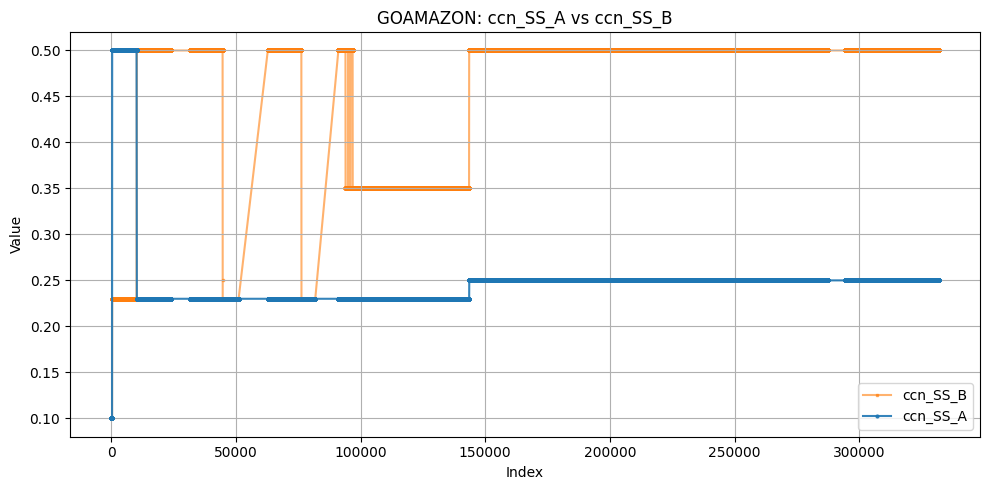

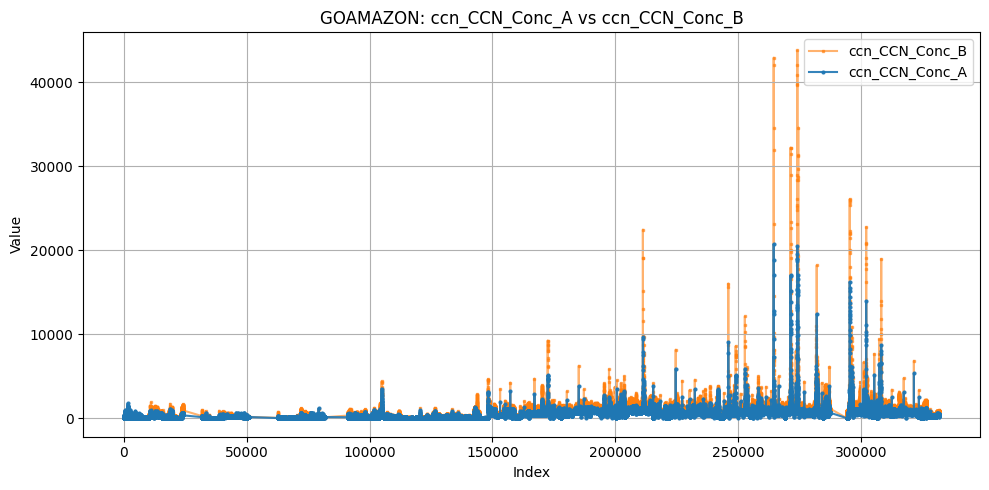

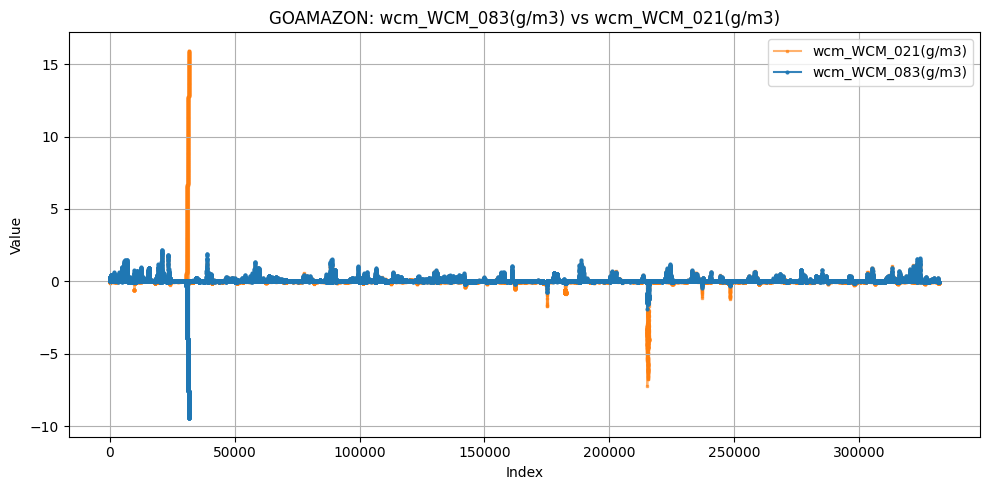

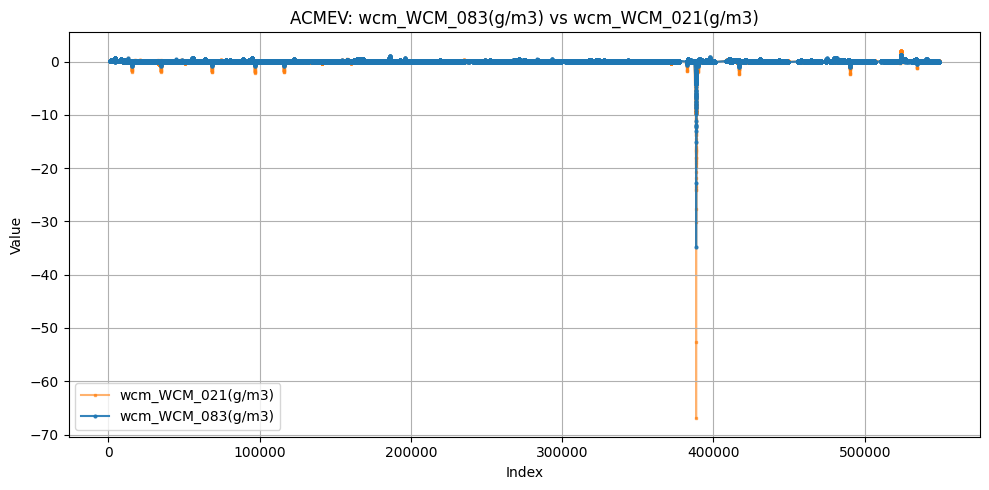

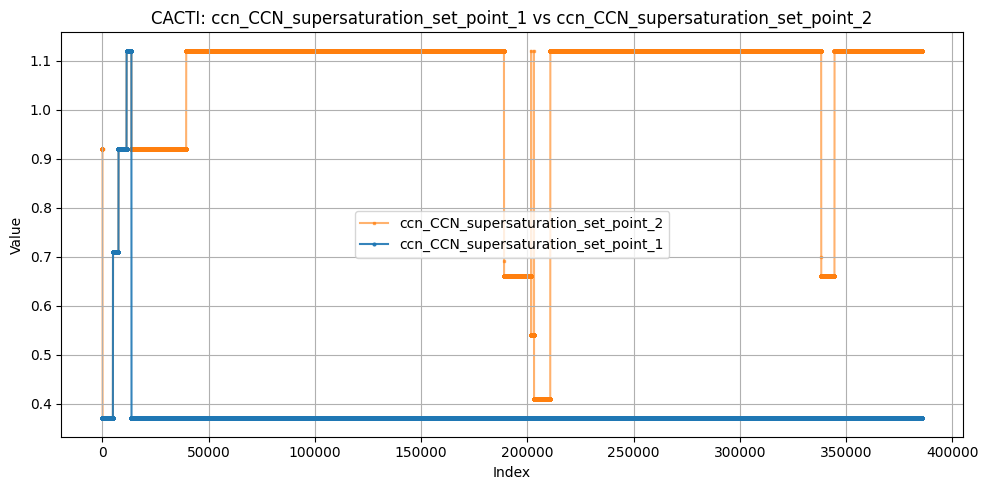

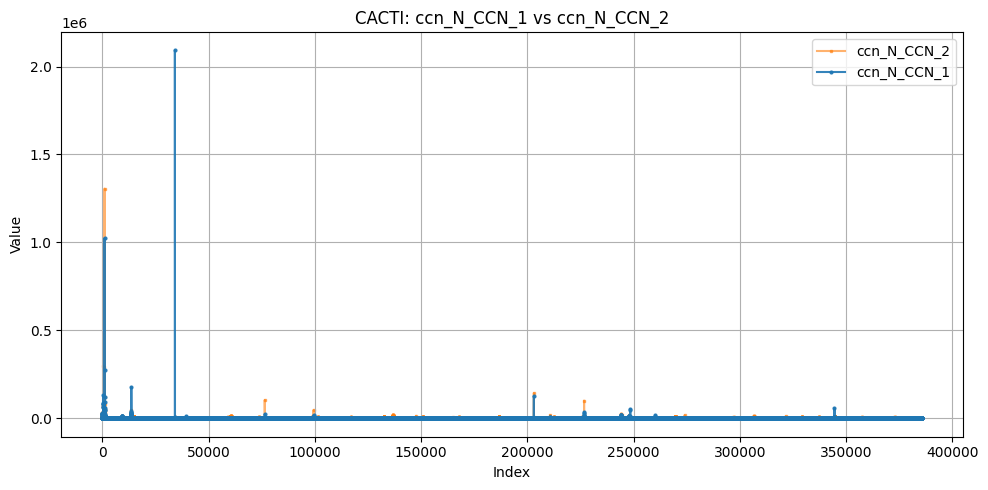

C:\Users\haika\AppData\Local\Temp\ipykernel_9028\2330560623.py:38: DtypeWarning: Columns (5,40,41,107,111) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


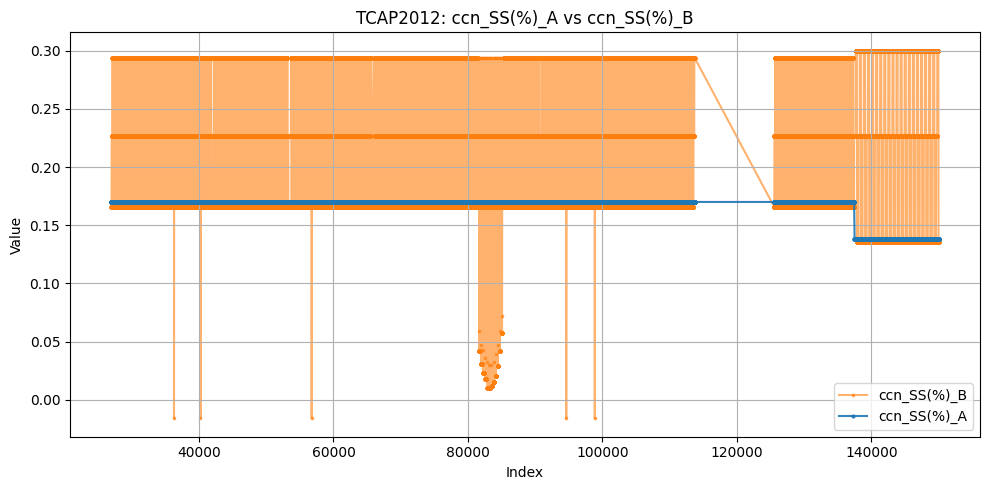

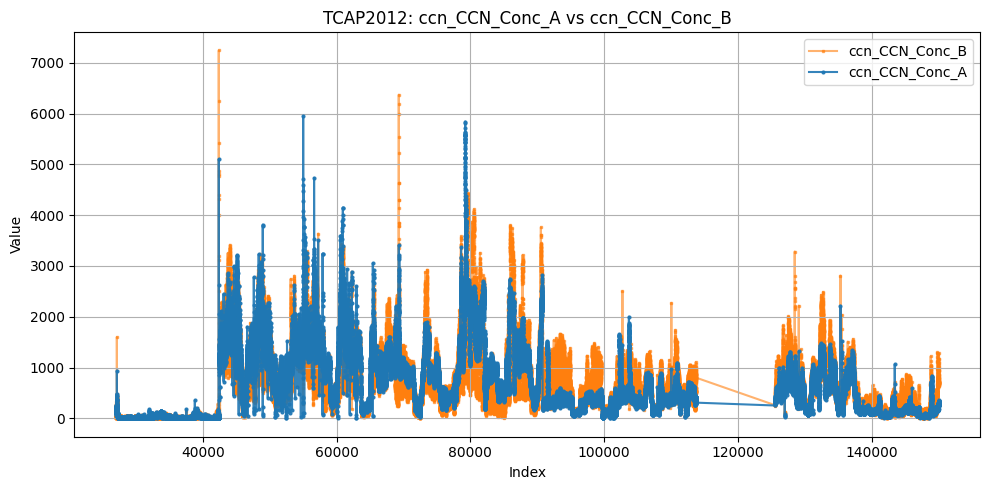

C:\Users\haika\AppData\Local\Temp\ipykernel_9028\2330560623.py:38: DtypeWarning: Columns (2,9,78,80,184,188) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


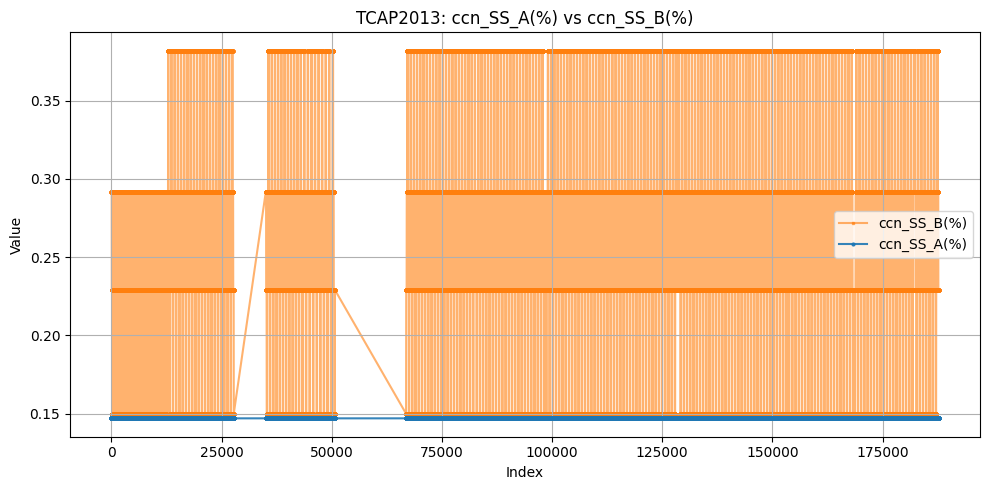

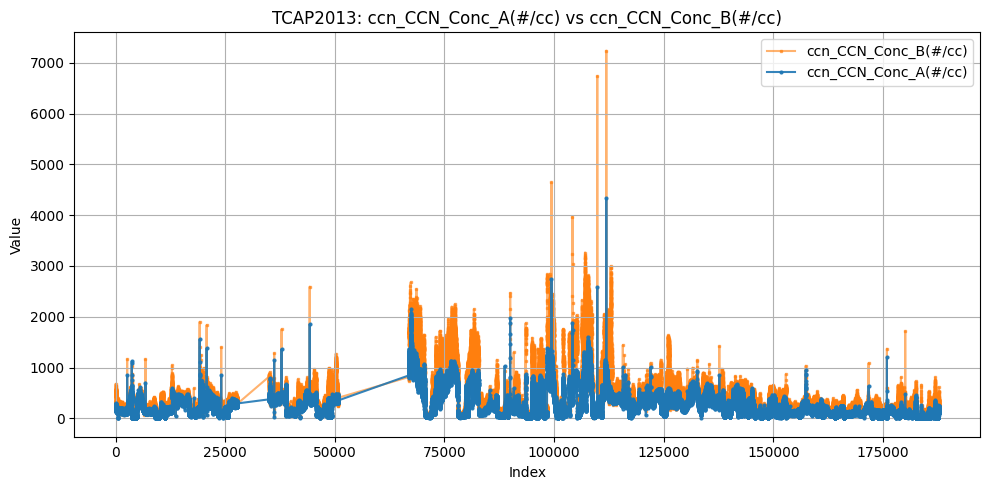

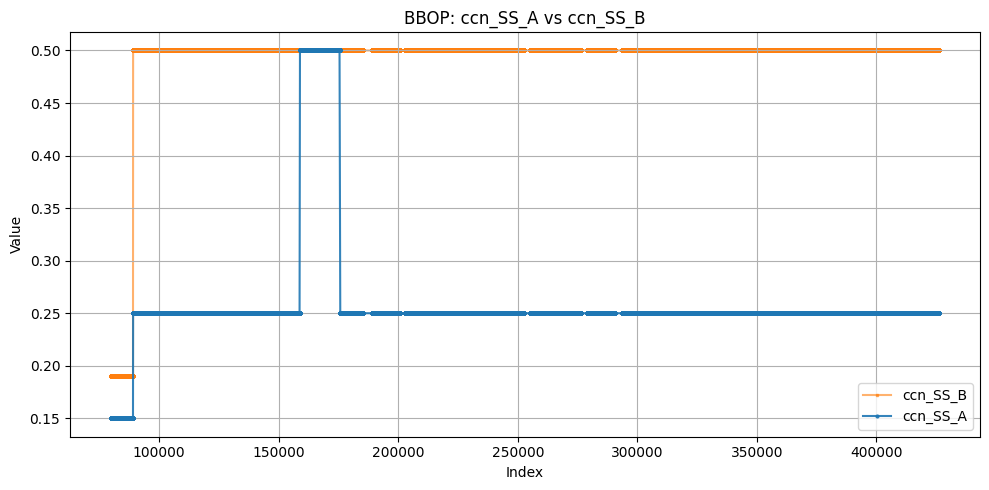

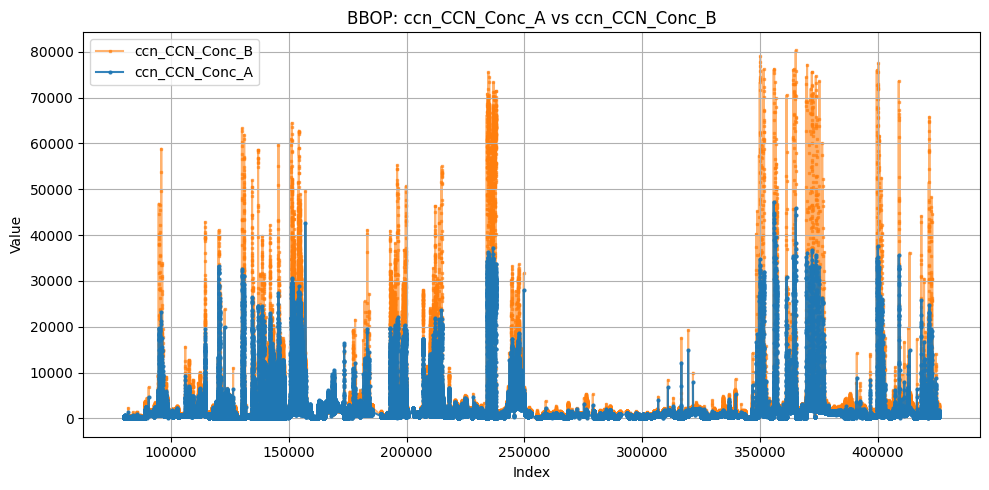

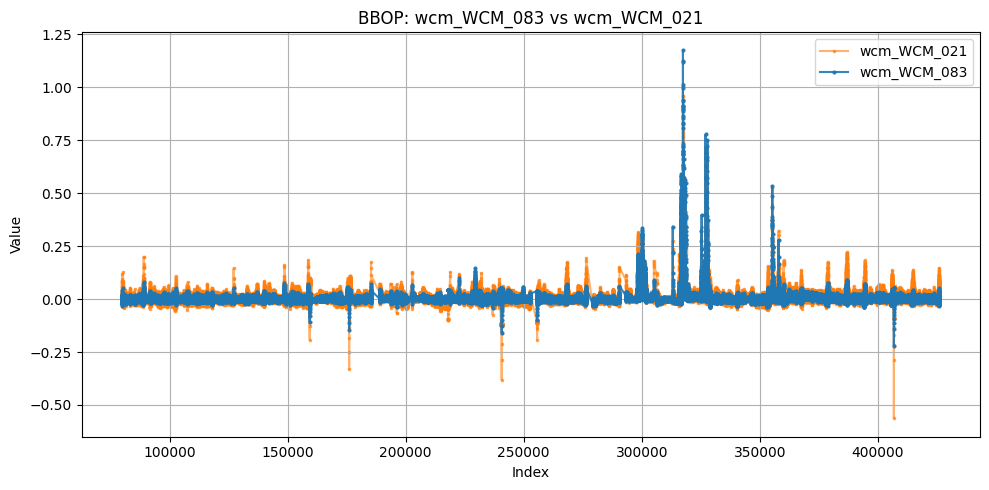

In [19]:
SENTINELS = [-9999, -2222, -9999.0, -2222.0, -100000, -100000.0]  # extend if needed
threshold_min = -1000                                             # values below this are invalid

for campaign, column_pairs in CAMPAIGN_DATA.items():
    try:
        df = read_campaign_df(campaign)
    except FileNotFoundError:
        warnings.warn(f"No data file found for {campaign}; skipping.")
        continue

    for col_x, col_y in column_pairs:
        if col_x not in df.columns or col_y not in df.columns:
            warnings.warn(f"{campaign}: columns {col_x}/{col_y} not found; skipping.")
            continue

        # 1. Select the two columns.
        clean_df = df[[col_x, col_y]].copy()

        # 2. Replace explicit sentinel codes with NA.
        clean_df = clean_df.replace(SENTINELS, pd.NA)

        # 3. Mask anything below the physical threshold.
        clean_df = clean_df.mask(clean_df < threshold_min, pd.NA)

        # 4. Drop rows that now have NA in either column.
        clean_df = clean_df.dropna()

        if not clean_df.empty:
            plot_columns(clean_df, campaign, col_x, col_y)
        else:
            warnings.warn(f"{campaign}: all rows NaN after cleaning {col_x}/{col_y}.")
